In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from sklearn.preprocessing import MinMaxScaler
from time import time
# from random import sample,shuffle

In [2]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [3]:
# import all the regressors you want to try ---
from sklearn.linear_model    import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm             import SVR
from sklearn.neighbors       import KNeighborsRegressor
from sklearn.tree            import DecisionTreeRegressor
from sklearn.ensemble        import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network  import MLPRegressor

from xgboost                 import XGBRegressor

In [4]:
import torch
import kgml_lib
Z_norm_reverse = kgml_lib.Z_norm_reverse
Z_norm_with_scaler = kgml_lib.Z_norm_with_scaler

In [5]:
# import Visulation functions
from time_series_models import scatter_result, plot_result, ML_train_and_test, ML_display_scores, ML_vis_prediction_results

In [6]:
# Load dataset
root_dir = 'E:/PyKGML/deposit_code_v2/'
data_path = root_dir +  'processed_data/'
output_path = root_dir + 'test_results/'

co2_finetune_file = data_path + 'co2_finetune_data.sav'
data = torch.load(co2_finetune_file, weights_only=False)

In [7]:
X_train = data['X_train'].cpu().numpy()
X_test = data['X_test'].cpu().numpy()
Y_train = data['Y_train'].cpu().numpy()
Y_test  = data['Y_test'].cpu().numpy()

y_scaler = data['y_scaler']

In [8]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, y_scaler.shape

((1, 37230, 19), (1, 37230, 2), (1, 8030, 19), (1, 8030, 2), (2, 2))

In [9]:
input_features = 19
output_features = 2
X_train = X_train.reshape(-1,input_features)
X_test  = X_test.reshape(-1,input_features)

y_train = Y_train.reshape(-1,output_features)
y_test  = Y_test.reshape(-1,output_features)

In [10]:
features = ['NEE','RECO']

### Here is an example by using XGBoost model

In [11]:
xgb_model = XGBRegressor(
    objective="reg:squarederror",
    device = 'cuda',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    n_jobs=-1,
    verbosity=0
)

model = MultiOutputRegressor(xgb_model)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [12]:
# Score on test set ---
for i, name in enumerate(features):
    rmse = np.sqrt(mean_squared_error(y_test[:, i], y_pred[:, i]))
    r2_value = r2_score(y_test[:,i], y_pred[:, i])
    print(f"Output {name}  RMSE = {rmse:.3f} R2 score = {r2_value:.3f}")

Output NEE  RMSE = 0.276 R2 score = 0.910
Output RECO  RMSE = 0.364 R2 score = 0.869


In [13]:
site = 1
years = int(y_test.shape[0] / 365)
years

22

In [14]:
_idx = 10
_y_pred = y_pred.reshape(1, years,365,-1)
_y_test = y_test.reshape(1, years,365,-1)
all_predictions_flat = _y_pred[0, _idx,:,:]
all_targets_flat     = _y_test[0, _idx,:,:]

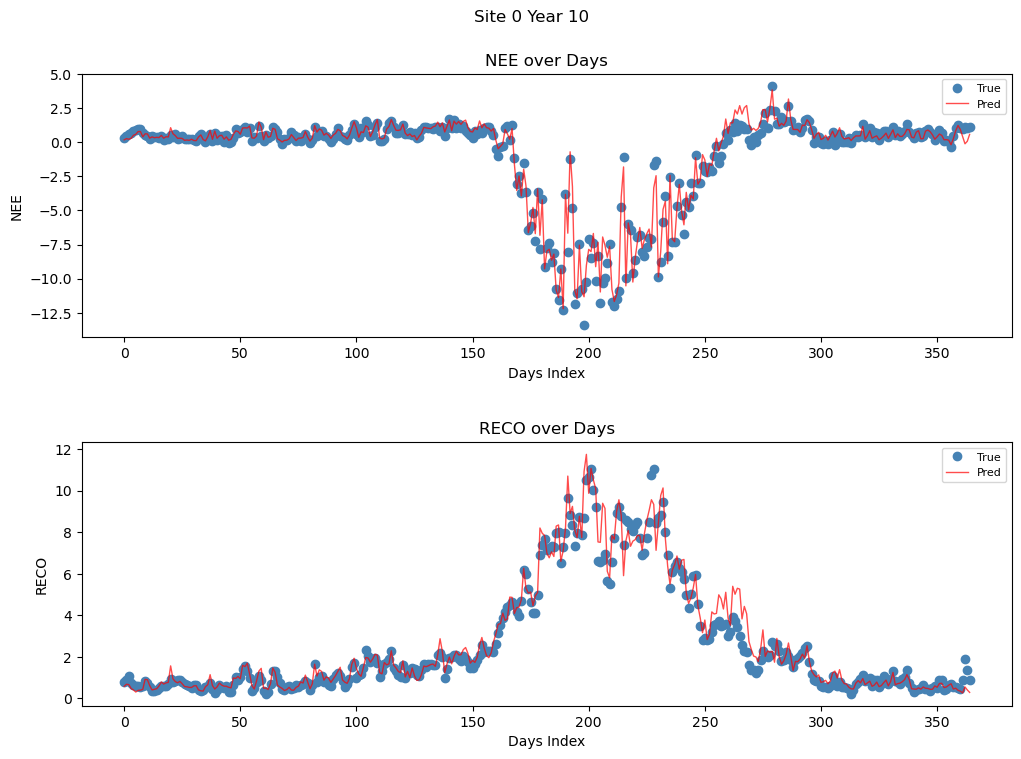

In [15]:
plot_result(y_scaler, features, all_predictions_flat,all_targets_flat, site=0, year=10)

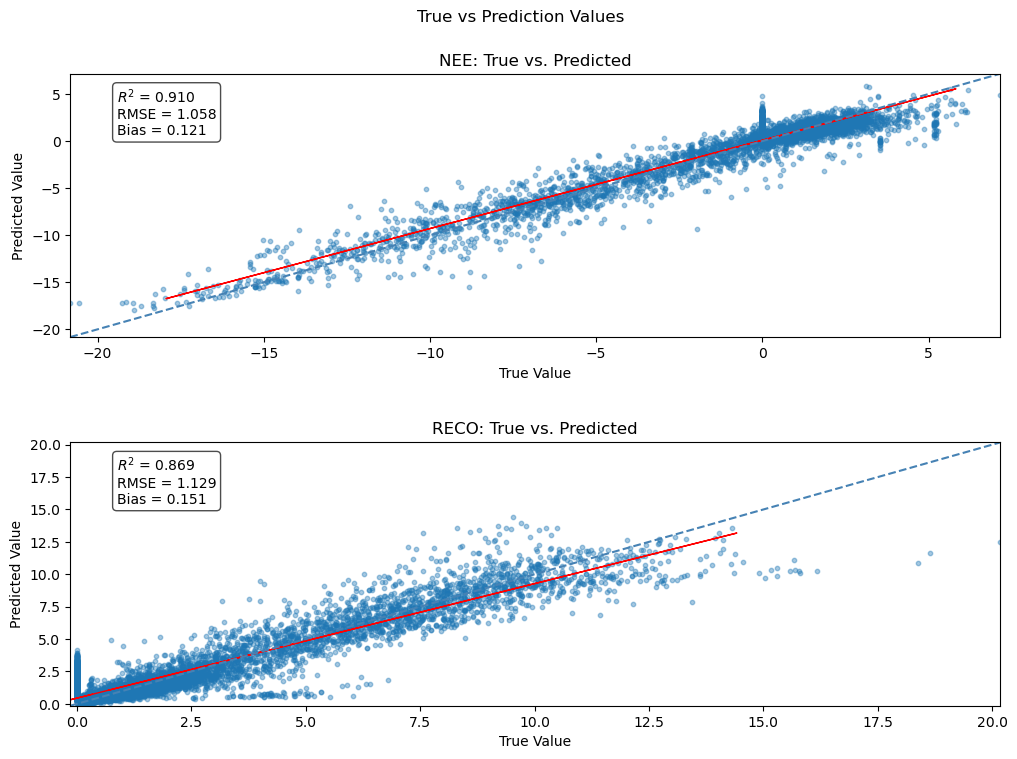

In [16]:
scatter_result(y_scaler, features, y_pred, y_test)

### Show how to train multiple Machine Learning models

In [17]:
# Define the models to compare ---
regressors = {
    "LinearRegression"       : LinearRegression(),
    "Ridge"                  : Ridge(alpha=1.0),
    "Lasso"                  : Lasso(alpha=0.1),
    "ElasticNet"             : ElasticNet(alpha=0.1, l1_ratio=0.5),
    "SVR (RBF)"              : SVR(kernel="rbf", C=1.0, epsilon=0.1),
    "KNeighbors"             : KNeighborsRegressor(n_neighbors=5),
    "DecisionTree"           : DecisionTreeRegressor(max_depth=5),
    "RandomForest"           : RandomForestRegressor(n_estimators=50, max_depth=7, n_jobs=-1),
    "GradientBoosting"       : GradientBoostingRegressor(n_estimators=100, learning_rate=0.1),
    "MLPRegressor"           : MLPRegressor(hidden_layer_sizes=(100,50), max_iter=200),
    "XGBRegressor"           : XGBRegressor(
                                   objective="reg:squarederror",
                                    tree_method='hist',      # ← use the GPU‐accelerated histogram algorithm
                                    device = 'cuda',
                                   n_estimators=100, max_depth=5, learning_rate=0.1,
                                   n_jobs=-1, verbosity=0)
}

In [18]:
output_features = ['NEE','RECO']
mean_scores, feature_scores, prediction_results = ML_train_and_test(regressors, X_train, X_test, y_train, y_test, output_features)

LinearRegression
Ridge
Lasso
ElasticNet
SVR (RBF)
KNeighbors
DecisionTree
RandomForest
GradientBoosting
MLPRegressor
XGBRegressor


In [19]:
ML_display_scores(mean_scores, feature_scores)

  Mean Scores   
Model                      R2       RMSE        MAE
------------------------------------------------
LinearRegression        0.862      0.130      0.234
Ridge                   0.862      0.130      0.233
Lasso                   0.822      0.168      0.290
ElasticNet              0.831      0.160      0.271
SVR (RBF)               0.868      0.125      0.228
KNeighbors              0.839      0.152      0.248
DecisionTree            0.867      0.126      0.242
RandomForest            0.883      0.111      0.216
GradientBoosting        0.890      0.104      0.207
MLPRegressor            0.861      0.131      0.228
XGBRegressor            0.890      0.104      0.204
      
  Each output feature's Scores   
              Method Feature        R2      RMSE       MAE
0   LinearRegression     NEE  0.879713  0.101757  0.205457
1   LinearRegression    RECO  0.843527  0.159016  0.261640
2              Ridge     NEE  0.879755  0.101722  0.205144
3              Ridge    RECO  0.8

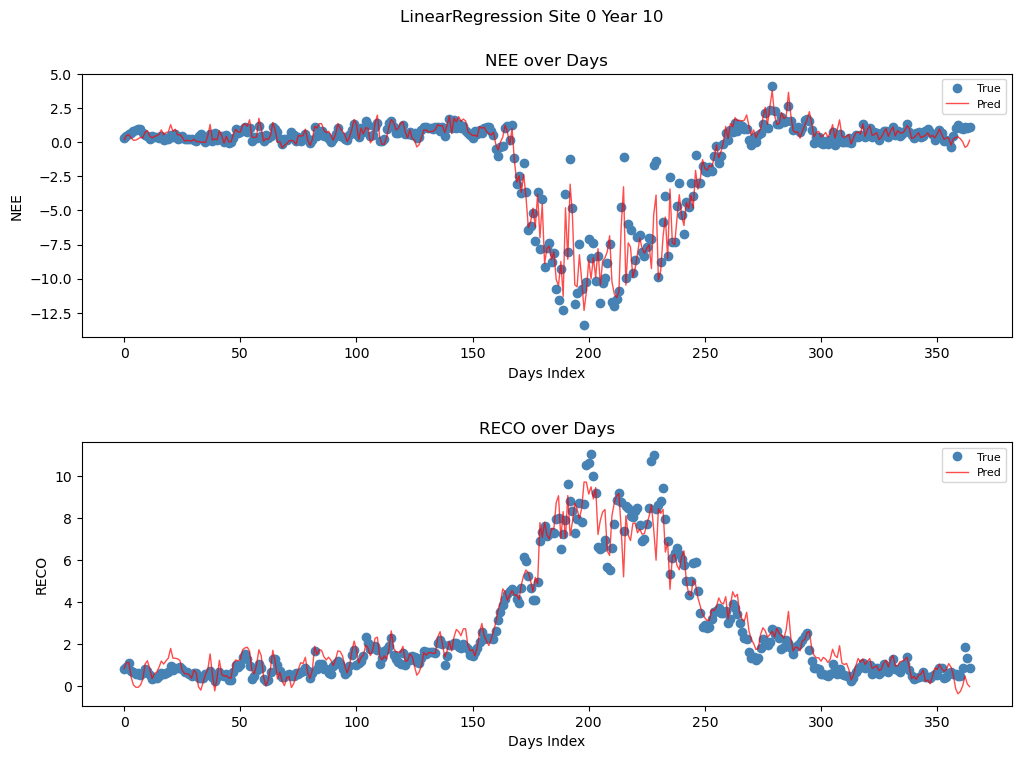

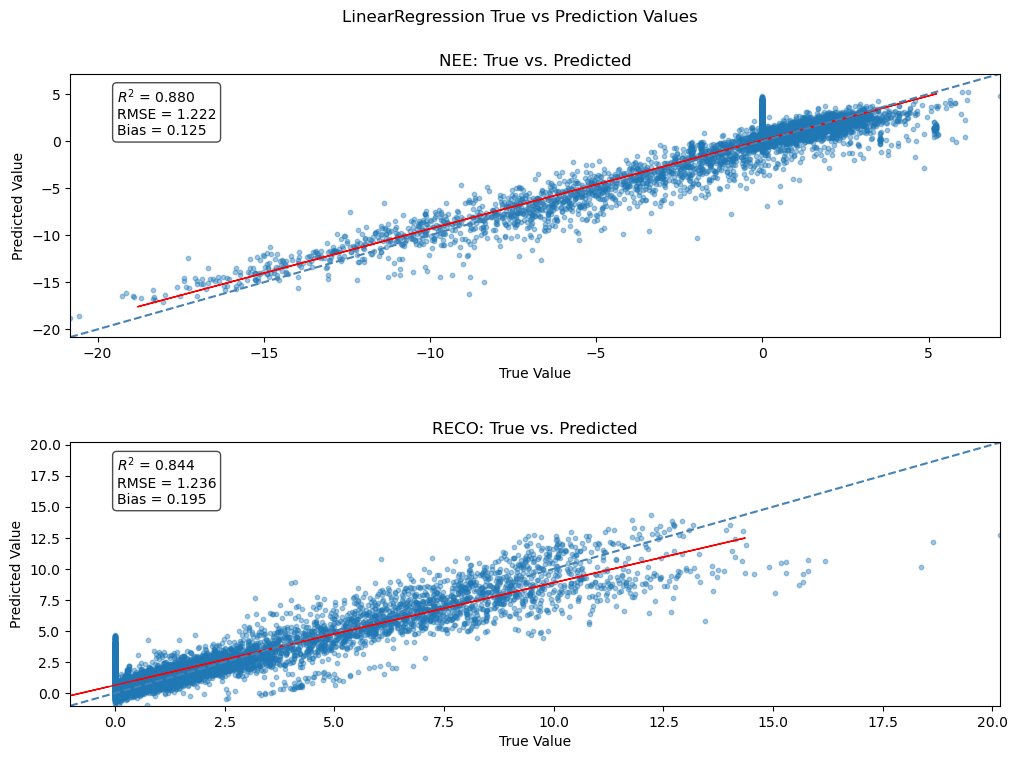

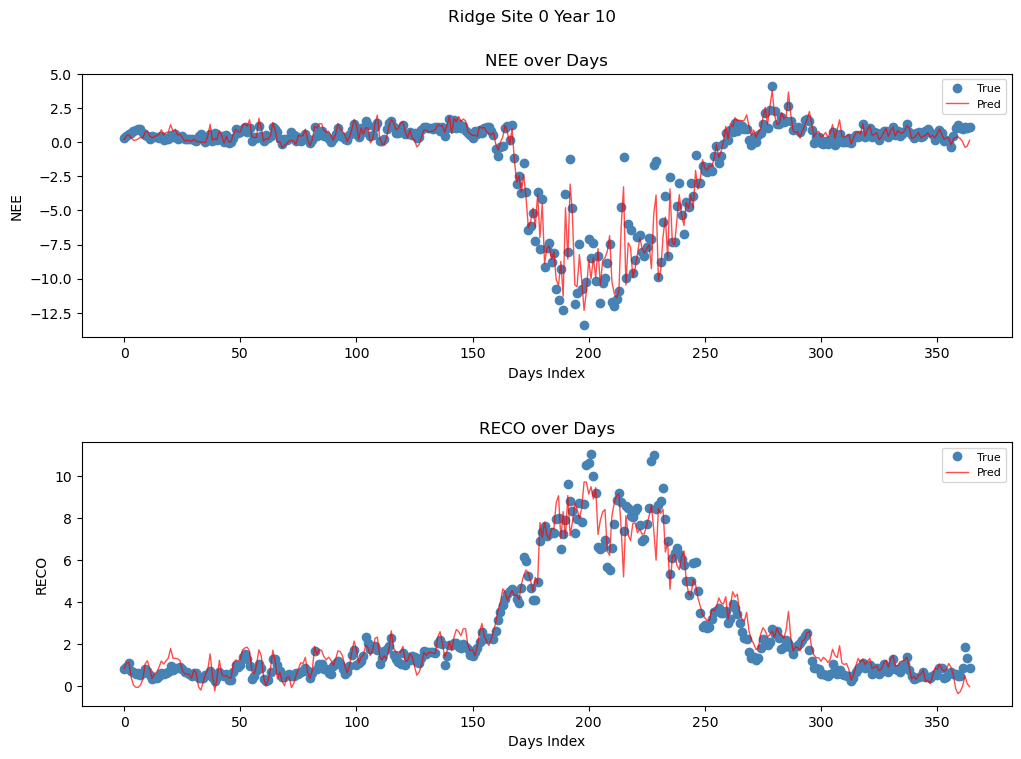

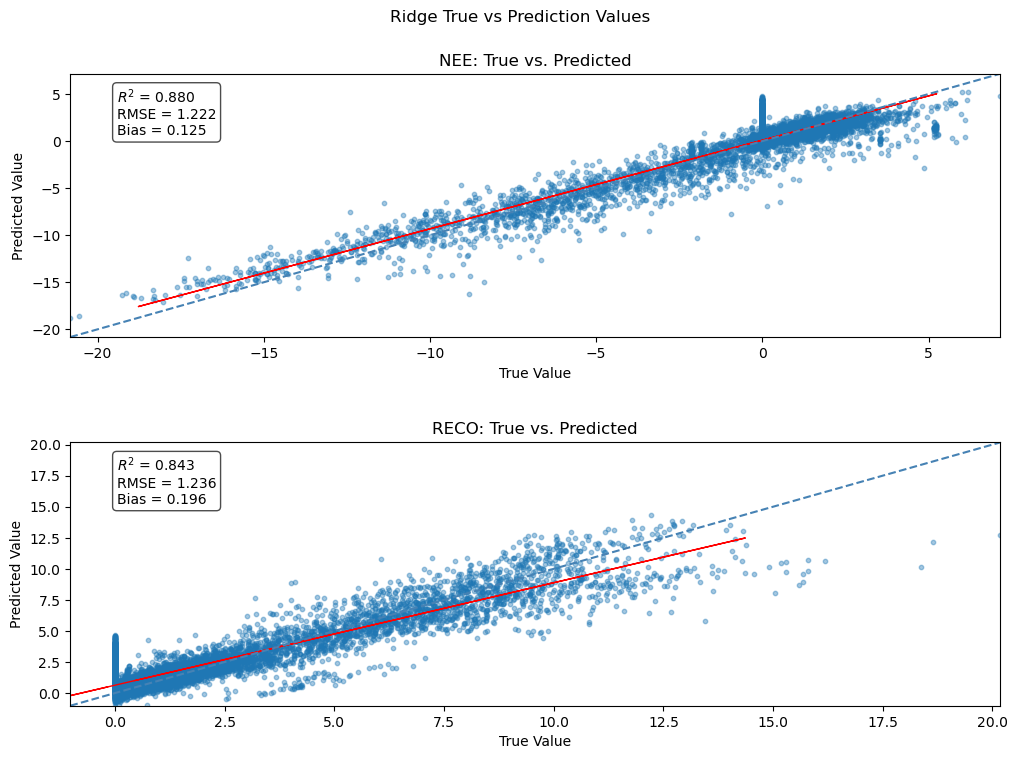

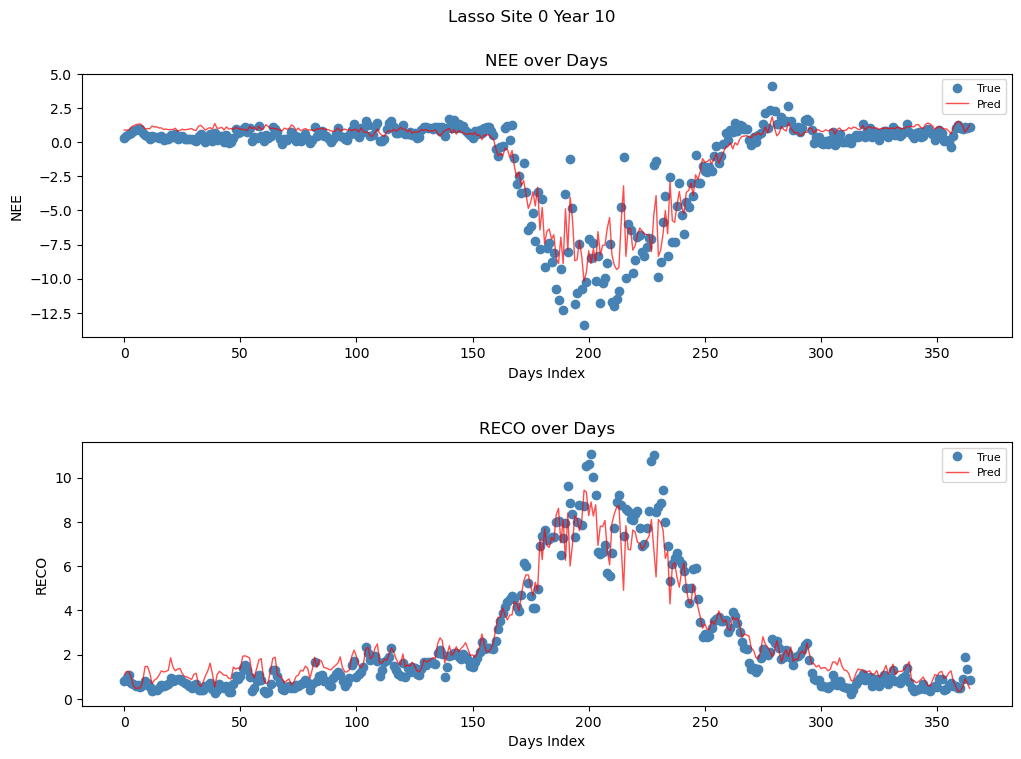

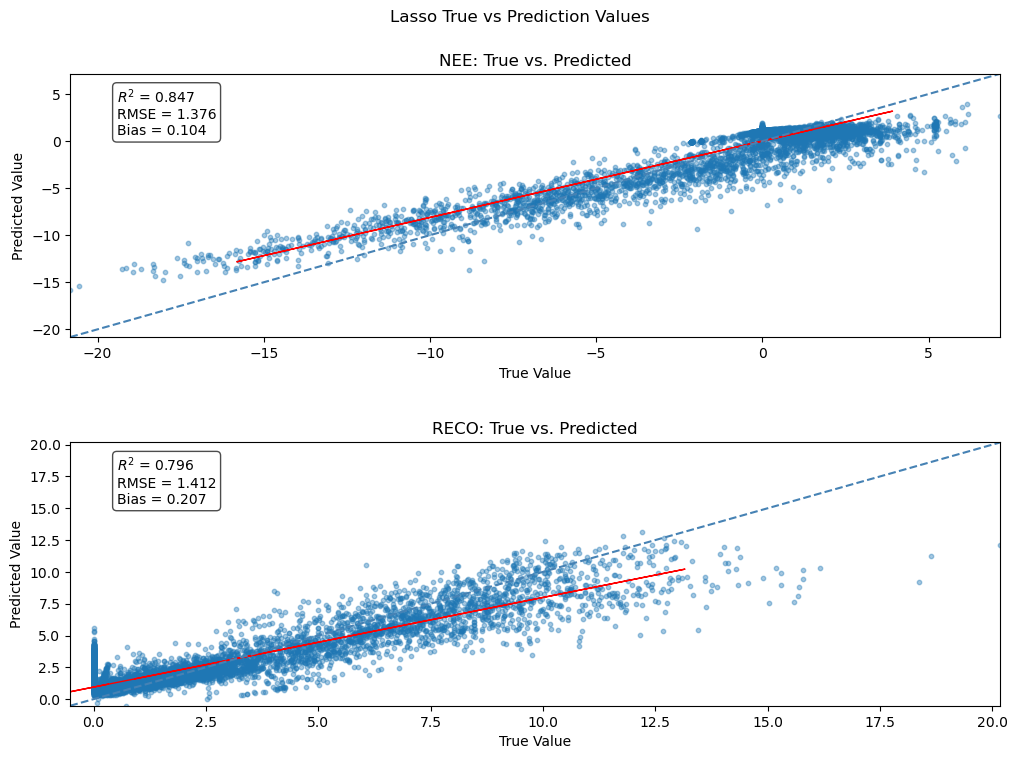

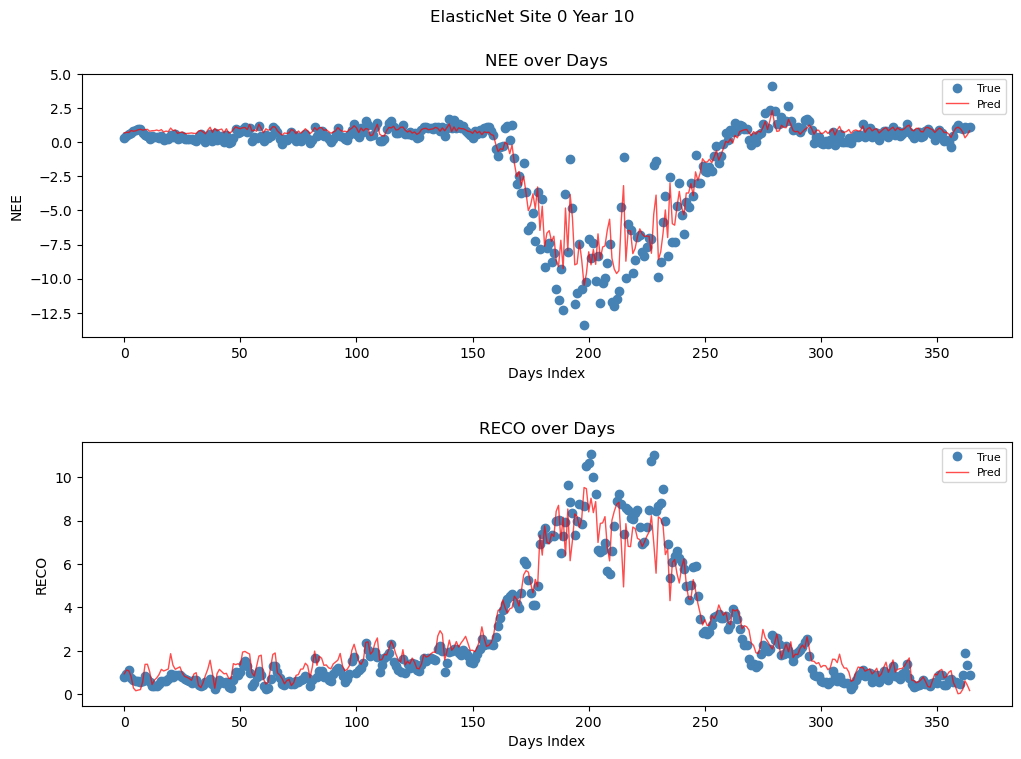

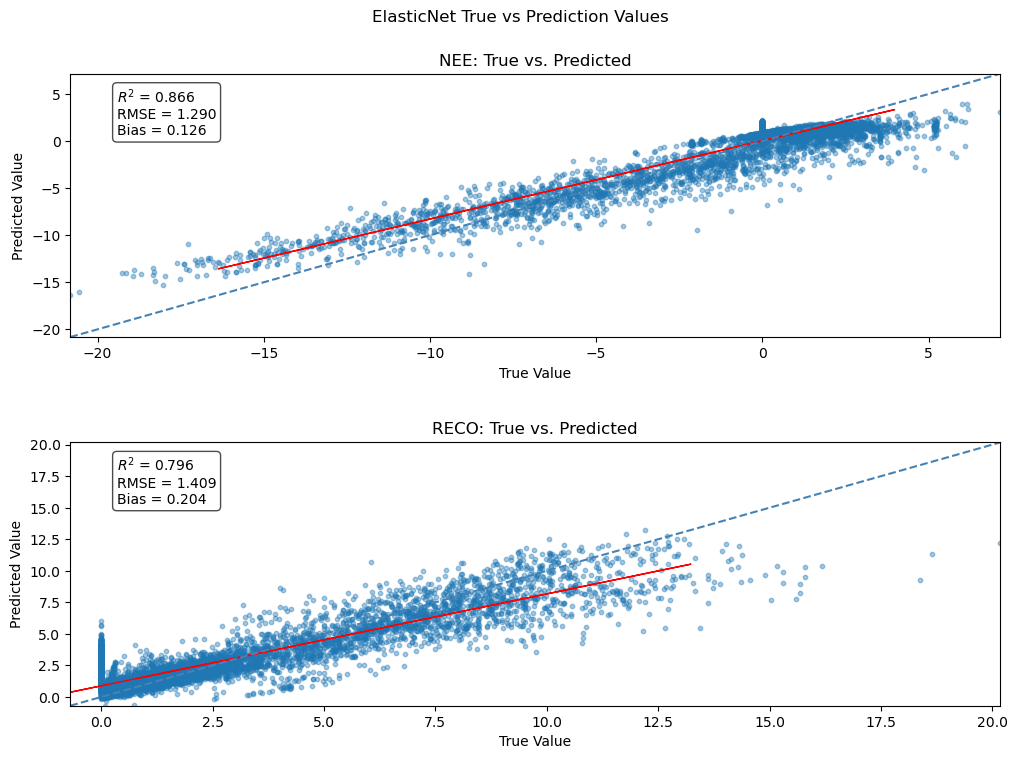

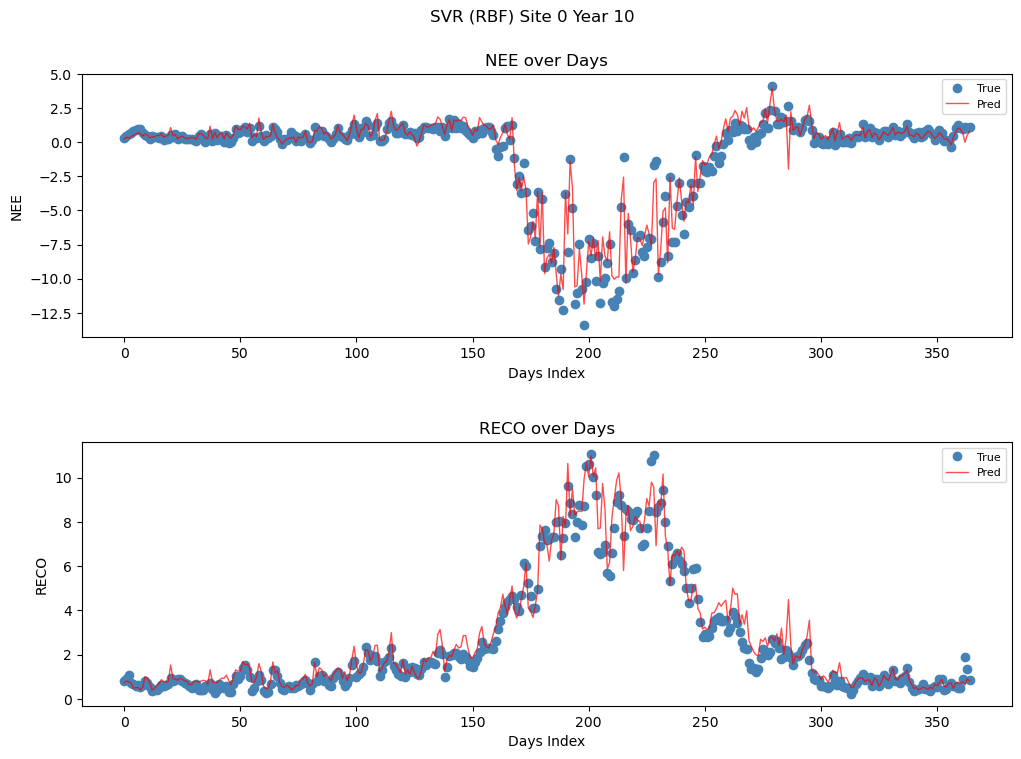

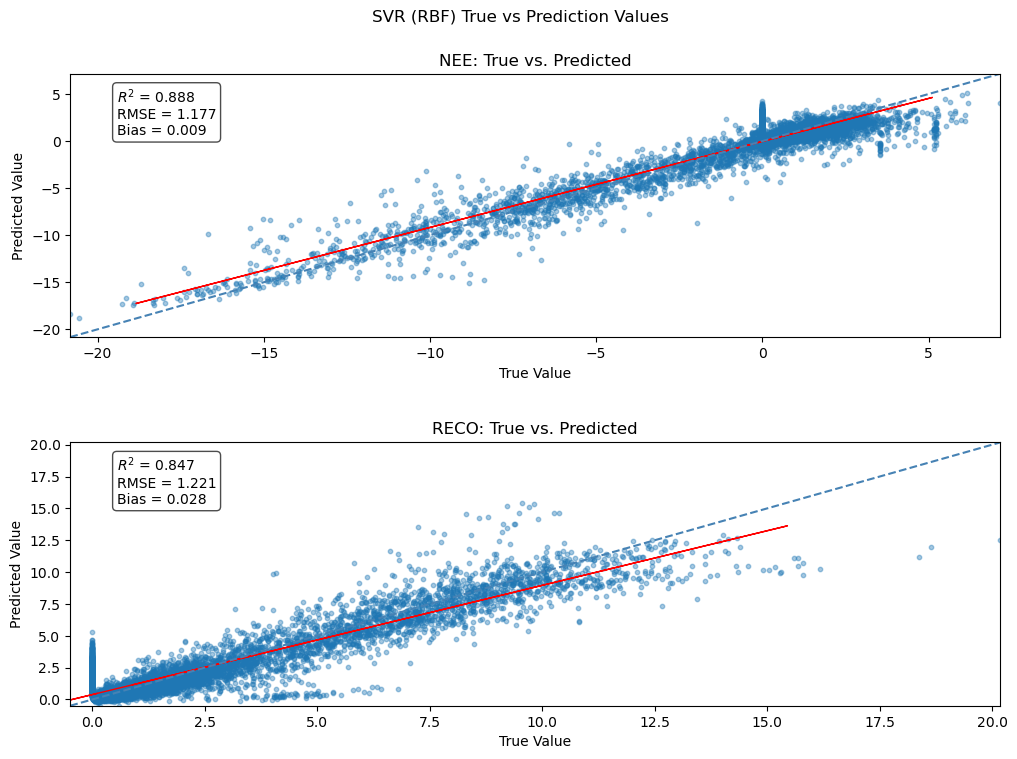

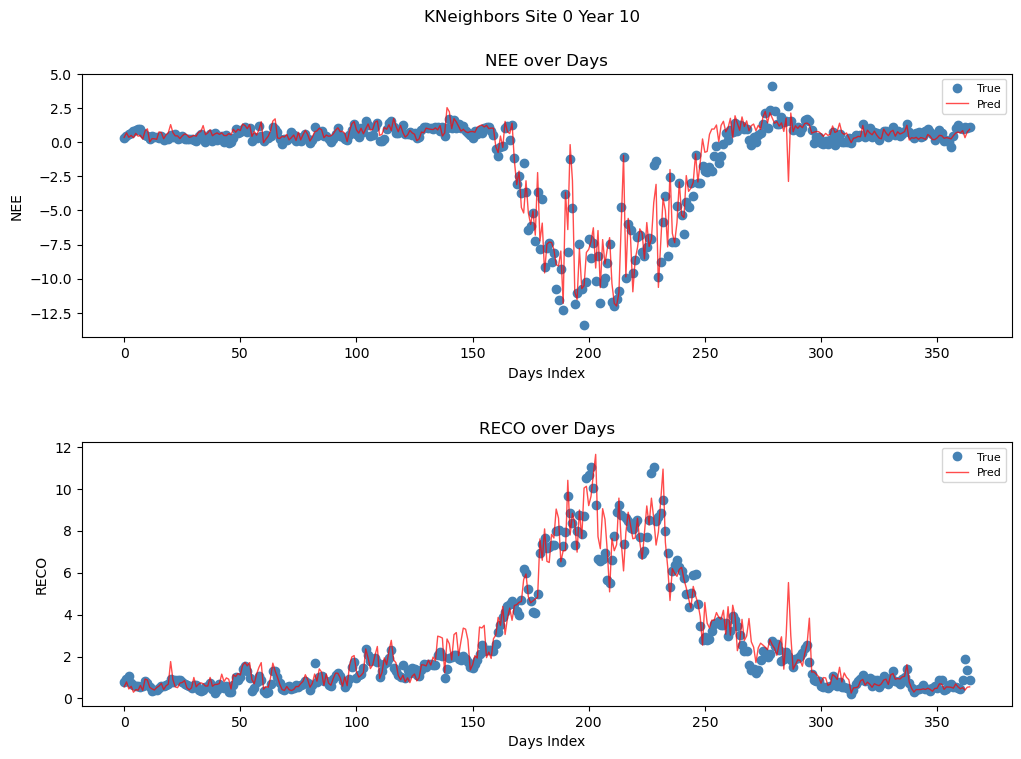

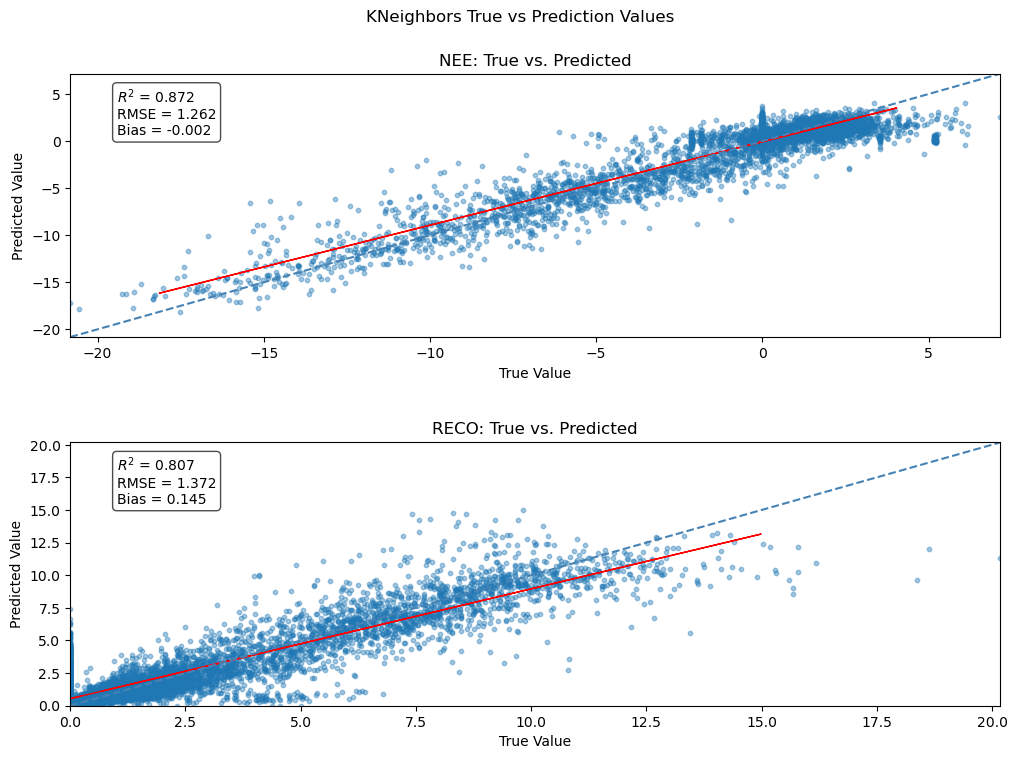

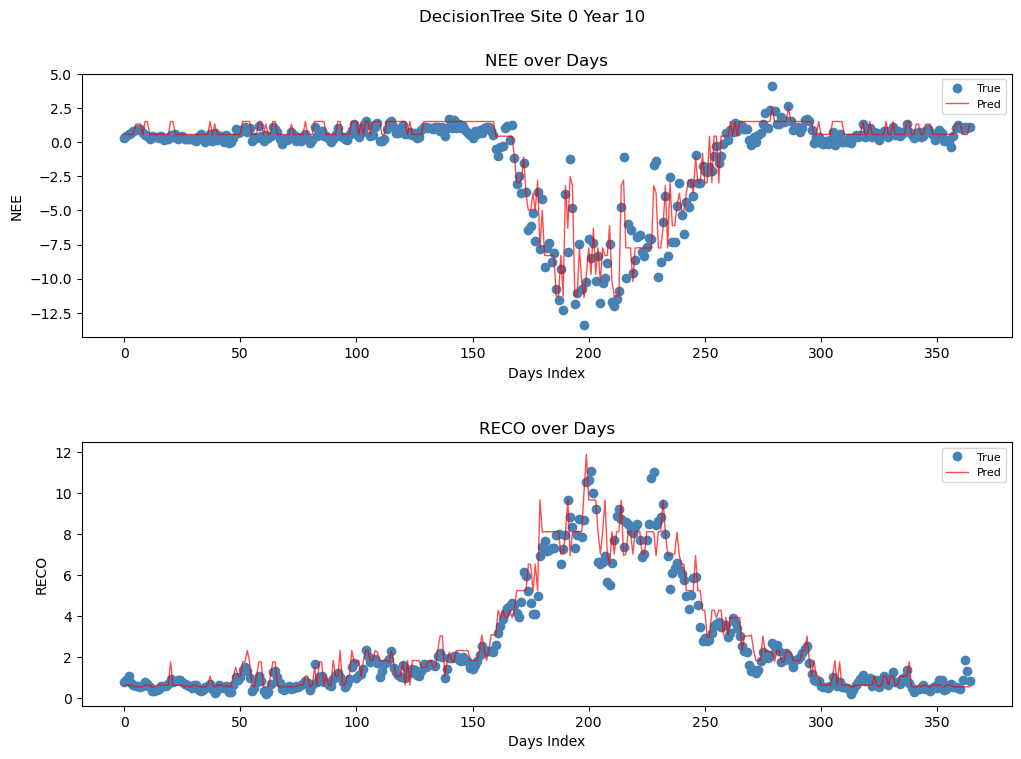

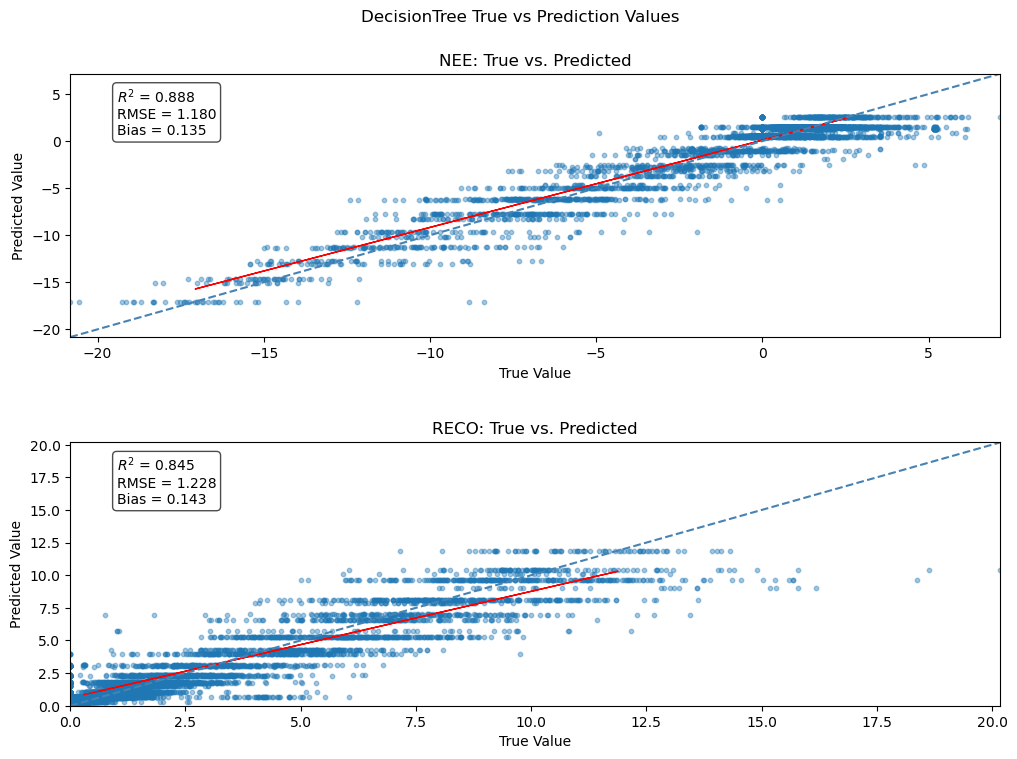

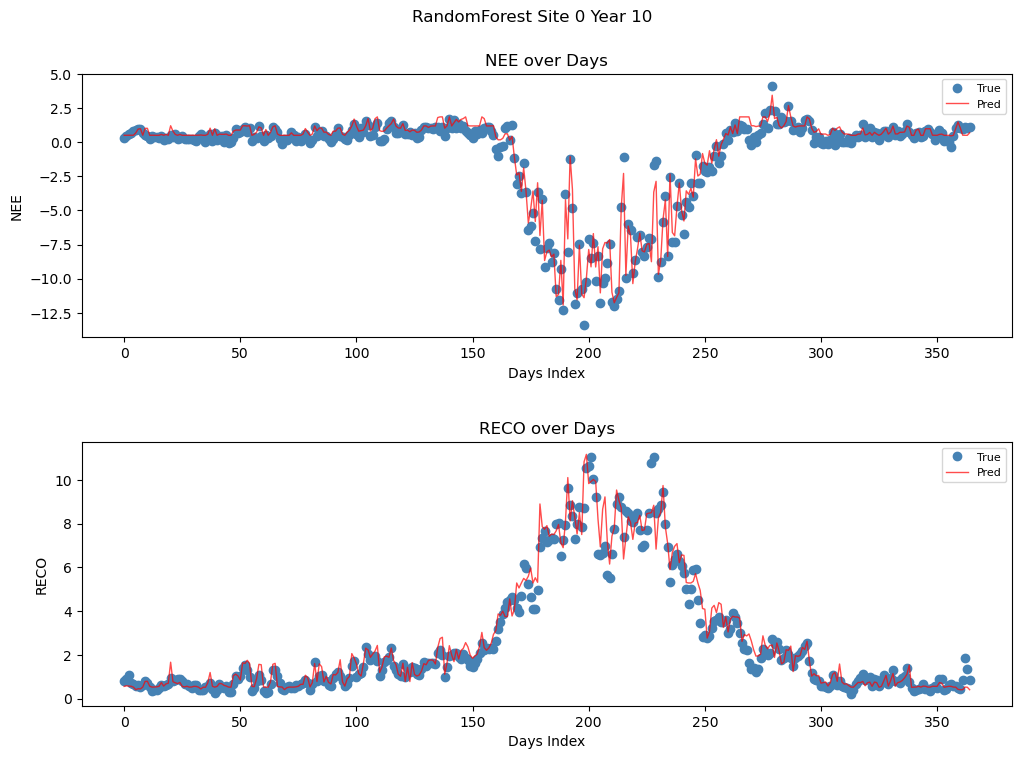

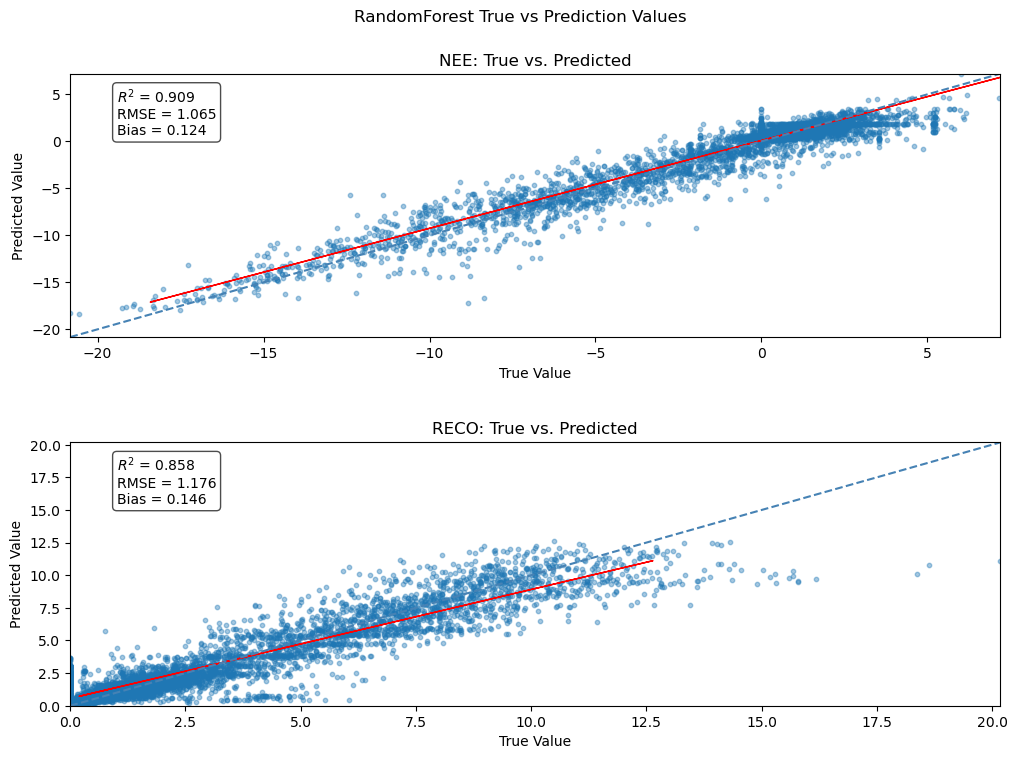

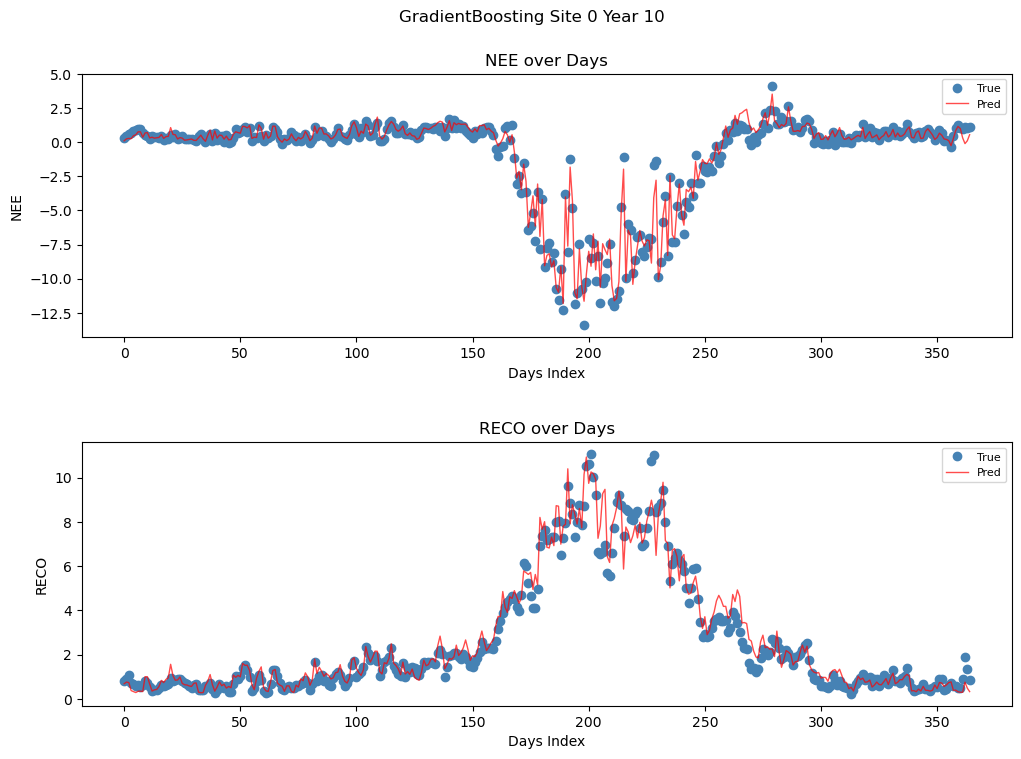

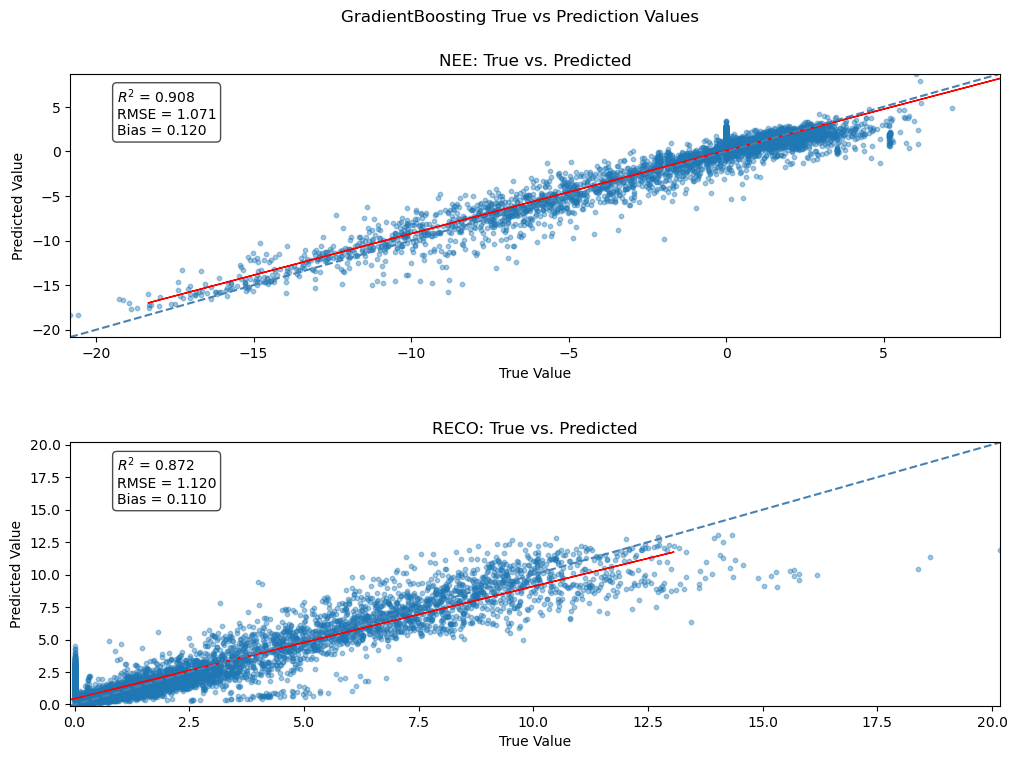

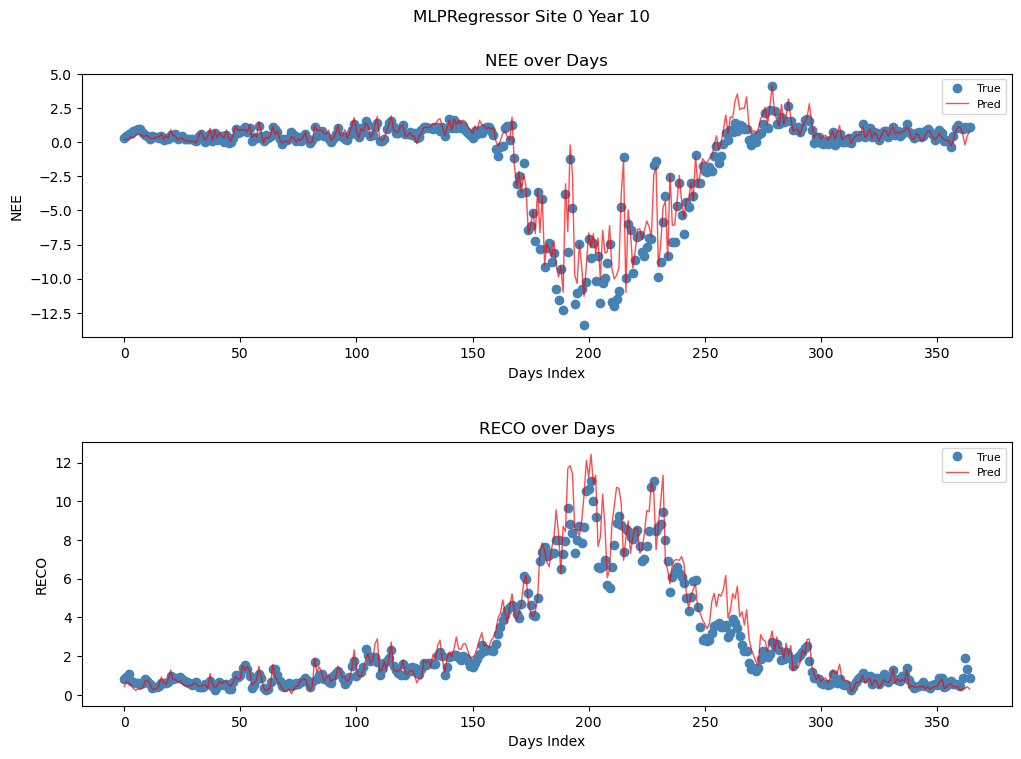

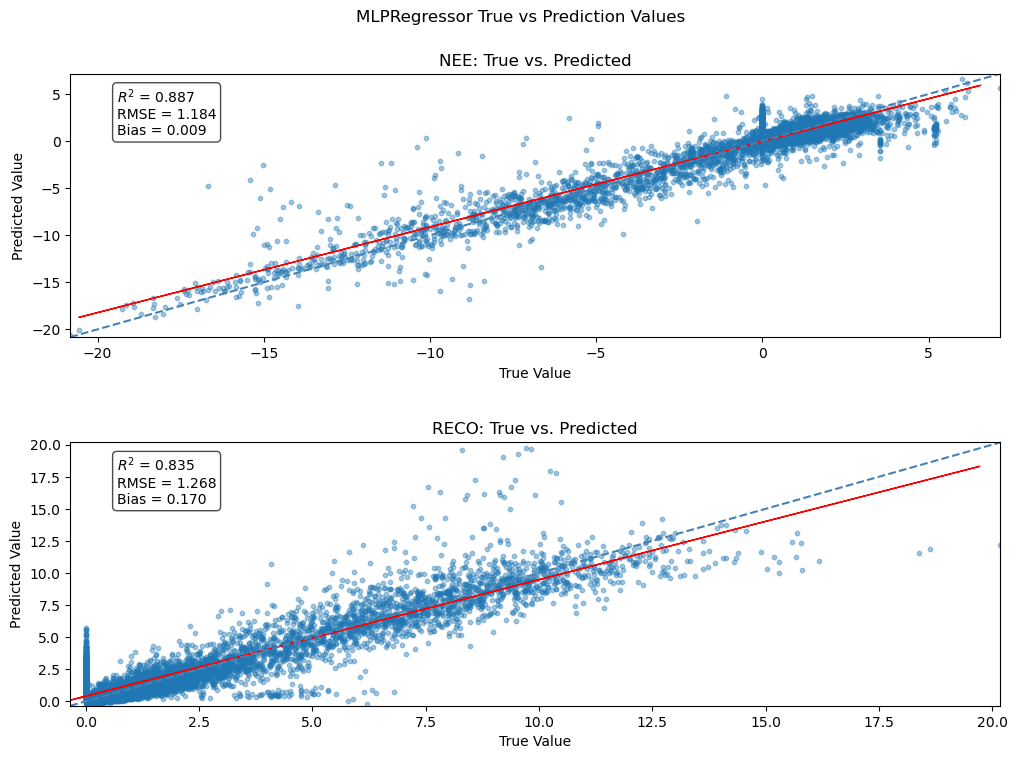

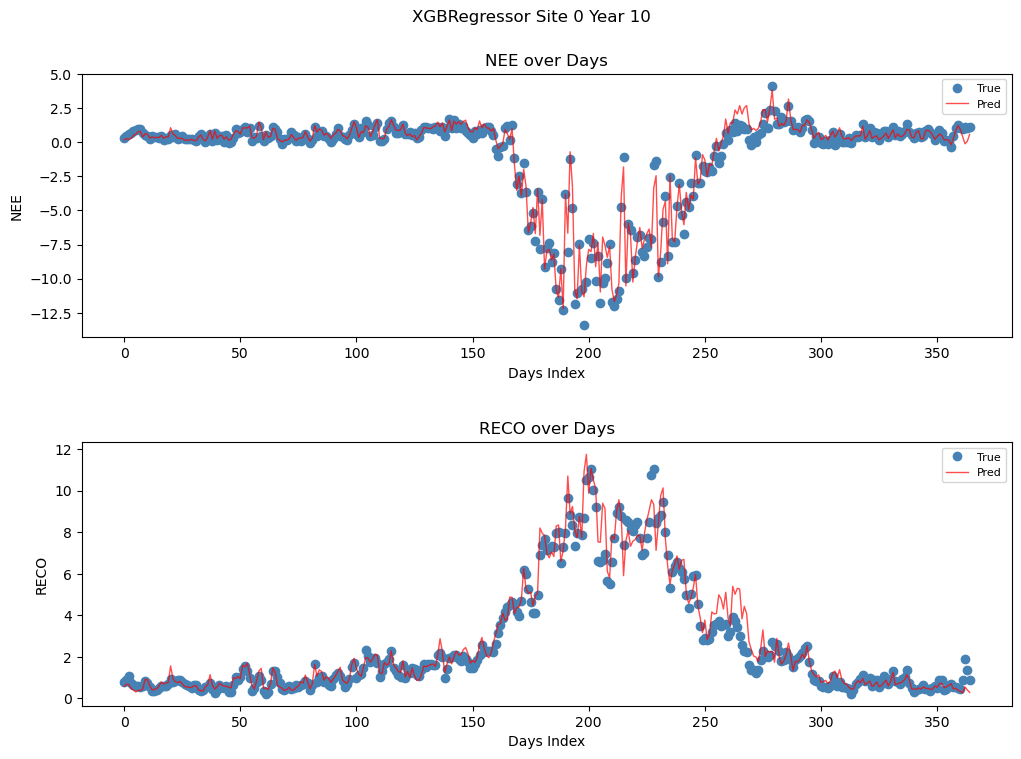

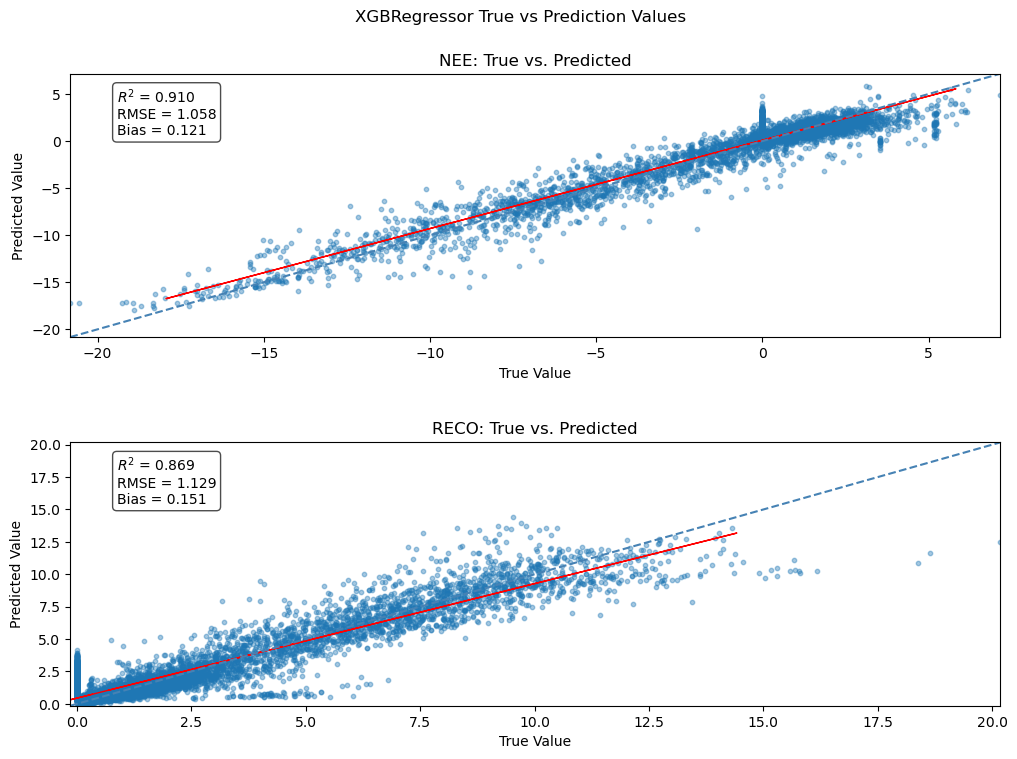

In [20]:
sites = 1 # Total sites
day_of_year = 365
years = int(y_test.shape[0] / 365) # Total years
choiced_site = 0
choiced_year = 10

ML_vis_prediction_results(prediction_results, output_features, y_scaler, sites, years, day_of_year, choiced_site, choiced_year)